Importing Libraries

In [25]:
import re
import os
import s3fs
import logging
# from data_ingestion import ingest_data_from_s3
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from general_functions import *
import matplotlib.pyplot as plt
import matplotlib.pyplot as pyplt
import numpy as np
from scipy.interpolate import make_interp_spline
import datetime
from scipy.ndimage import gaussian_filter1d

from pyspark.sql.window import Window
from pyspark.sql.functions import *

logging.basicConfig(format='%(asctime)s - %(message)s', level=logging.INFO)
logger = logging.getLogger('Data_Processing')
logger.info('main.py Script started')

2024-05-27 12:23:22,804 - main.py Script started


In [26]:
def generating_publisher_id_with_maximum_queries(spark, destination_path):
    try:

        #data manipulation before graph generation
        # spark = SparkSession.builder.master("local[*]").appName("click_logs").config("spark.sql.legacy.timeParserPolicy","LEGACY").getOrCreate()
        # df = spark.read.parquet("C:/Users/Admin/Downloads/read_public_s3/clean/") 
        df  = spark.read.parquet(destination_path)
        
        print("data reading done",df.count())
        df = df.withColumn("file_creation_date", date_format('file_creation_date', "yyyy-MM-dd"))
        # display(df)
        df.count()

        # COMMAND ----------

        df.printSchema()

        # COMMAND ----------

        # # publisher_id  = get_publisher_id_column_name(df)
        window_spec = Window.partitionBy('publisher_id').orderBy("publisher_id")

        # x = df.filter((df.file_creation_date).cast(StringType()).like('%2024-05-20%'))
        x = df.withColumn("total_count_of_click", sum(col('total_clicks')).over(window_spec))
        rank_spec = Window.partitionBy().orderBy(desc(col("total_count_of_click")))

        x = x.withColumn("rank", dense_rank().over(rank_spec))

        x = x.filter(x.rank<=5)
        # display(x)
        unique_publisher_id = list(set(x.select("publisher_id").rdd.flatMap(lambda x: x).collect()))
        print(unique_publisher_id)

        # # df = df.select(publisher_id, "count_of_click", "file_creation_date")
        # display(x)

        # COMMAND ----------

        v = df.filter(df.publisher_id.isin(unique_publisher_id))
        v.count()
        v = v.groupBy("publisher_id", "file_creation_date").agg(sum(col("total_clicks")))
        v = v.sort("publisher_id", "file_creation_date", ascending=True)
        # display(v)
        v.show()

        # COMMAND ----------

        v.printSchema()
        return v
    except Exception as e:
        logger.info(f"Error has been encountered at apply_transformations {e}")






def generatring_line_graph_for_top_5_publishers(v):
    try:


        pyplt.rcParams["figure.figsize"] = (50,15)
        plt.rcParams["figure.autolayout"] = True
        # fig, ax = plt.subplots(figsize=(5, 2.7), layout='constrained')
        color_schema = ['r','y','g','k','c']
        unique_publisher_id = list(set(v.select("publisher_id").rdd.flatMap(lambda x: x).collect()))
        for i in range(len(unique_publisher_id)):
            print(unique_publisher_id[i])
            a = v.filter(v.publisher_id == unique_publisher_id[i])
            x_axis = a.select("file_creation_date").rdd.flatMap(lambda x: x).collect()
            y_axis = np.array(list(map(lambda x: int(x),a.select("sum(total_clicks)").rdd.flatMap(lambda x: x).collect())))//1000
            print(y_axis)
            # plt.ylim(min(y_axis), max(y_axis))
        
            # plt.plot(x_axis, y_axis, f'o-{color_schema[i]}',label=unique_publisher_id[i], linewidth=10)
            # Apply Gaussian filter for smoothing
            y_smooth = gaussian_filter1d(y_axis, sigma=1)

            # Plot original points
            # plt.plot(dates, y, 'o', alpha=0.6, label='Original data')

            # Plot smooth curve
            plt.plot(x_axis, y_smooth,  f'x-{color_schema[i]}',marker='x',label=unique_publisher_id[i], linewidth=4)


        plt.xlabel('Date', size = 50, labelpad=38)
        plt.ylabel('Clicks (x 1000)', size = 50, labelpad= 38)
        plt.title('QPS', size = 50, pad = 6)
        plt.xticks(fontsize=42,rotation=45,ha='right')
        plt.yticks(fontsize=42)
        # plt.
        specific_y_ticks = np.arange(0, 1200, 100)

        plt.gca().set_yticks(specific_y_ticks)
        plt.grid(visible = True,axis='y', which='both',color='k', linestyle='-', linewidth=0.6, in_layout=True)
        plt.grid(visible = True,axis='x', which='both',color='k', linestyle='-', linewidth=0.6, in_layout=True)
        # plt.yaxis.grid(True, which='minor')
        # plt.grid()

        # Just for appearance's sake
        # ax.margins(0.05)
        # ax.axis('tight')
        # plt.tight_layout()
        plt.legend(prop={'size':50})
        plt.savefig('C:/Users/Admin/Downloads/read_public_s3/graph/line_graph.png', dpi=300, bbox_inches='tight')
        plt.show()
    except Exception as e:
        logger.info(f"Error has been encountered at apply_transformations {e}")

In [30]:
def apply_transformations(spark,destination_path):
    try:
        print(destination_path)
        folder_path = []
        # actual_path = destination_path.replace("\\", "/")+'/Landing/click_log/2024/05/'
        actual_path = destination_path
        for outside in os.listdir(actual_path):
            for inside in os.listdir(f'{actual_path}/{outside}'):
                folder_path.append(f'{outside}/{inside}')


        for path in folder_path:
            print(path)

            df = spark.read.option("inferSchema", True).option("mode", "PERMISSIVE").json(f"{actual_path}{path}/")

            df = df.select('*', "ip_geo.*", "query.*").drop("query", "ip_geo")
            df = df.toDF(*get_unique_column_names(df.columns))

            df = df.drop(*get_duplicate_column_names(df))

            df = df.withColumn("real_filepath", input_file_name())

            df = df.withColumn("actual_file" , split(df.real_filepath, '/',limit=-1))
            df = df.withColumn("count_file", size(df.actual_file))
            df = df.withColumn("actual_file" , df.actual_file[col("count_file")-1]).drop("count_file")
            df = df.withColumn("file_creation_date", get_file_generation_date_udf(col("actual_file")))
            df = df.withColumn("date", split(col("file_creation_date"), " ").getItem(0))
            df.show()
            df = df.withColumn("file_creation_date", date_format(to_timestamp("file_creation_date", "yyyy-MM-dd HH-mm"), "yyyy-MM-dd HH:mm"))
            df = df.withColumn("date", to_timestamp("date", "yyyy-MM-dd"))
            publisher_id  = get_publisher_id_column_name(df)
            df.printSchema()

            df = df.na.fill("null")
            
            # print("this is the column structure", df.columns)
            df = df.withColumnRenamed(publisher_id, "publisher_id")
            df = df.select("publisher_id", "file_creation_date", "actual_file","date")
            df = df.withColumn("publisher_id", when(length(col("publisher_id")) > 6, regexp_extract(col("publisher_id"), "^(va-\d{3})|^(VA-\d{3})",0)).otherwise(col("publisher_id")))
            df = df.withColumn("path", lit(path))
            
            
            df = df.groupBy("publisher_id", "file_creation_date", "actual_file","date").agg(count("publisher_id").alias("total_clicks"))
            # # print("this is the window function count", df.count())

            df.write.partitionBy("date").mode("append").format("parquet").save(str(os.getcwd()).replace("\\", "/")+f'/clean1')
            logger.info(f"successfully saved data of {path} with partiton column date")
                # display(df)
                # if path == '20/07':
            break
        return str(os.getcwd()).replace("\\", "/")+f'/clean1'
    except Exception as e:
        logger.info(f"Error has been encountered at apply_transformations {e}")




2024-05-27 12:25:26,580 - ingestion of data started from s3-path datasci-assignment/click_log/2024/05/
2024-05-27 12:25:26,582 - ingestion of data Completed successfully at location c:/Users/Admin/Downloads/read_public_s3/Landing1/
2024-05-27 12:25:26,589 - SparkSession Created Successfully
2024-05-27 12:25:26,590 - apply_transformations function started successfully reading data from location : c:/Users/Admin/Downloads/read_public_s3/Landing1/


c:/Users/Admin/Downloads/read_public_s3/Landing1/
10/00
+-------------+-------------+-------------+--------------------+--------------------+------+--------------+----------------+--------------------+--------------+--------------------+--------------------+-------------+-------+------------+----------+-------+-------+-------------+--------+------+-------+--------------------+------------------+----------------+-------------+--------------------+--------------------+--------------------+-------------------+----------+
|campaign_id_0| click_time_1|creative_id_2|         device_id_3|              gaid_4|idfa_5|          ip_6|isGlobalIpFlag_7|        p_click_id_8|publisher_id_9|              req_10| sub_publisher_id_11| timestamp_12|city_13|city_name_14|country_15| lat_16| lon_17|metro_code_18|state_19|zip_20|_tk__21|         click_id_23|is_incentivized_27|        model_28|os_version_29|       user_agent_32|       real_filepath|         actual_file| file_creation_date|      date|
+-------

2024-05-27 12:25:38,768 - successfully saved data of 10/00 with partiton column date
2024-05-27 12:25:38,769 - apply_transformations function completed saved parquet at location: c:/Users/Admin/Downloads/read_public_s3/clean1


data reading done 2695
root
 |-- publisher_id: string (nullable = true)
 |-- file_creation_date: string (nullable = true)
 |-- actual_file: string (nullable = true)
 |-- total_clicks: long (nullable = true)
 |-- date: string (nullable = true)

['VA-570', 'VA-506', 'VA-618', 'VA-294', 'VA-496']
+------------+------------------+-----------------+
|publisher_id|file_creation_date|sum(total_clicks)|
+------------+------------------+-----------------+
|      VA-294|        2024-05-10|            78285|
|      VA-496|        2024-05-10|           244825|
|      VA-506|        2024-05-10|            88310|
|      VA-570|        2024-05-10|            74300|
|      VA-618|        2024-05-10|            80560|
+------------+------------------+-----------------+

root
 |-- publisher_id: string (nullable = true)
 |-- file_creation_date: string (nullable = true)
 |-- sum(total_clicks): long (nullable = true)

VA-570
[74]


C:\Users\Admin\AppData\Local\Temp\ipykernel_36960\1356292576.py:83: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "x-r" (-> marker='x'). The keyword argument will take precedence.
  plt.plot(x_axis, y_smooth,  f'x-{color_schema[i]}',marker='x',label=unique_publisher_id[i], linewidth=4)
2024-05-27 12:25:44,385 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-05-27 12:25:44,388 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


VA-506


C:\Users\Admin\AppData\Local\Temp\ipykernel_36960\1356292576.py:83: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "x-y" (-> marker='x'). The keyword argument will take precedence.
  plt.plot(x_axis, y_smooth,  f'x-{color_schema[i]}',marker='x',label=unique_publisher_id[i], linewidth=4)
2024-05-27 12:25:46,413 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-05-27 12:25:46,414 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


[88]
VA-618


C:\Users\Admin\AppData\Local\Temp\ipykernel_36960\1356292576.py:83: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "x-g" (-> marker='x'). The keyword argument will take precedence.
  plt.plot(x_axis, y_smooth,  f'x-{color_schema[i]}',marker='x',label=unique_publisher_id[i], linewidth=4)
2024-05-27 12:25:48,426 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-05-27 12:25:48,428 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


[80]
VA-294


C:\Users\Admin\AppData\Local\Temp\ipykernel_36960\1356292576.py:83: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "x-k" (-> marker='x'). The keyword argument will take precedence.
  plt.plot(x_axis, y_smooth,  f'x-{color_schema[i]}',marker='x',label=unique_publisher_id[i], linewidth=4)
2024-05-27 12:25:50,440 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-05-27 12:25:50,441 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


[78]
VA-496


C:\Users\Admin\AppData\Local\Temp\ipykernel_36960\1356292576.py:83: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "x-c" (-> marker='x'). The keyword argument will take precedence.
  plt.plot(x_axis, y_smooth,  f'x-{color_schema[i]}',marker='x',label=unique_publisher_id[i], linewidth=4)
2024-05-27 12:25:52,537 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-05-27 12:25:52,539 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


[244]


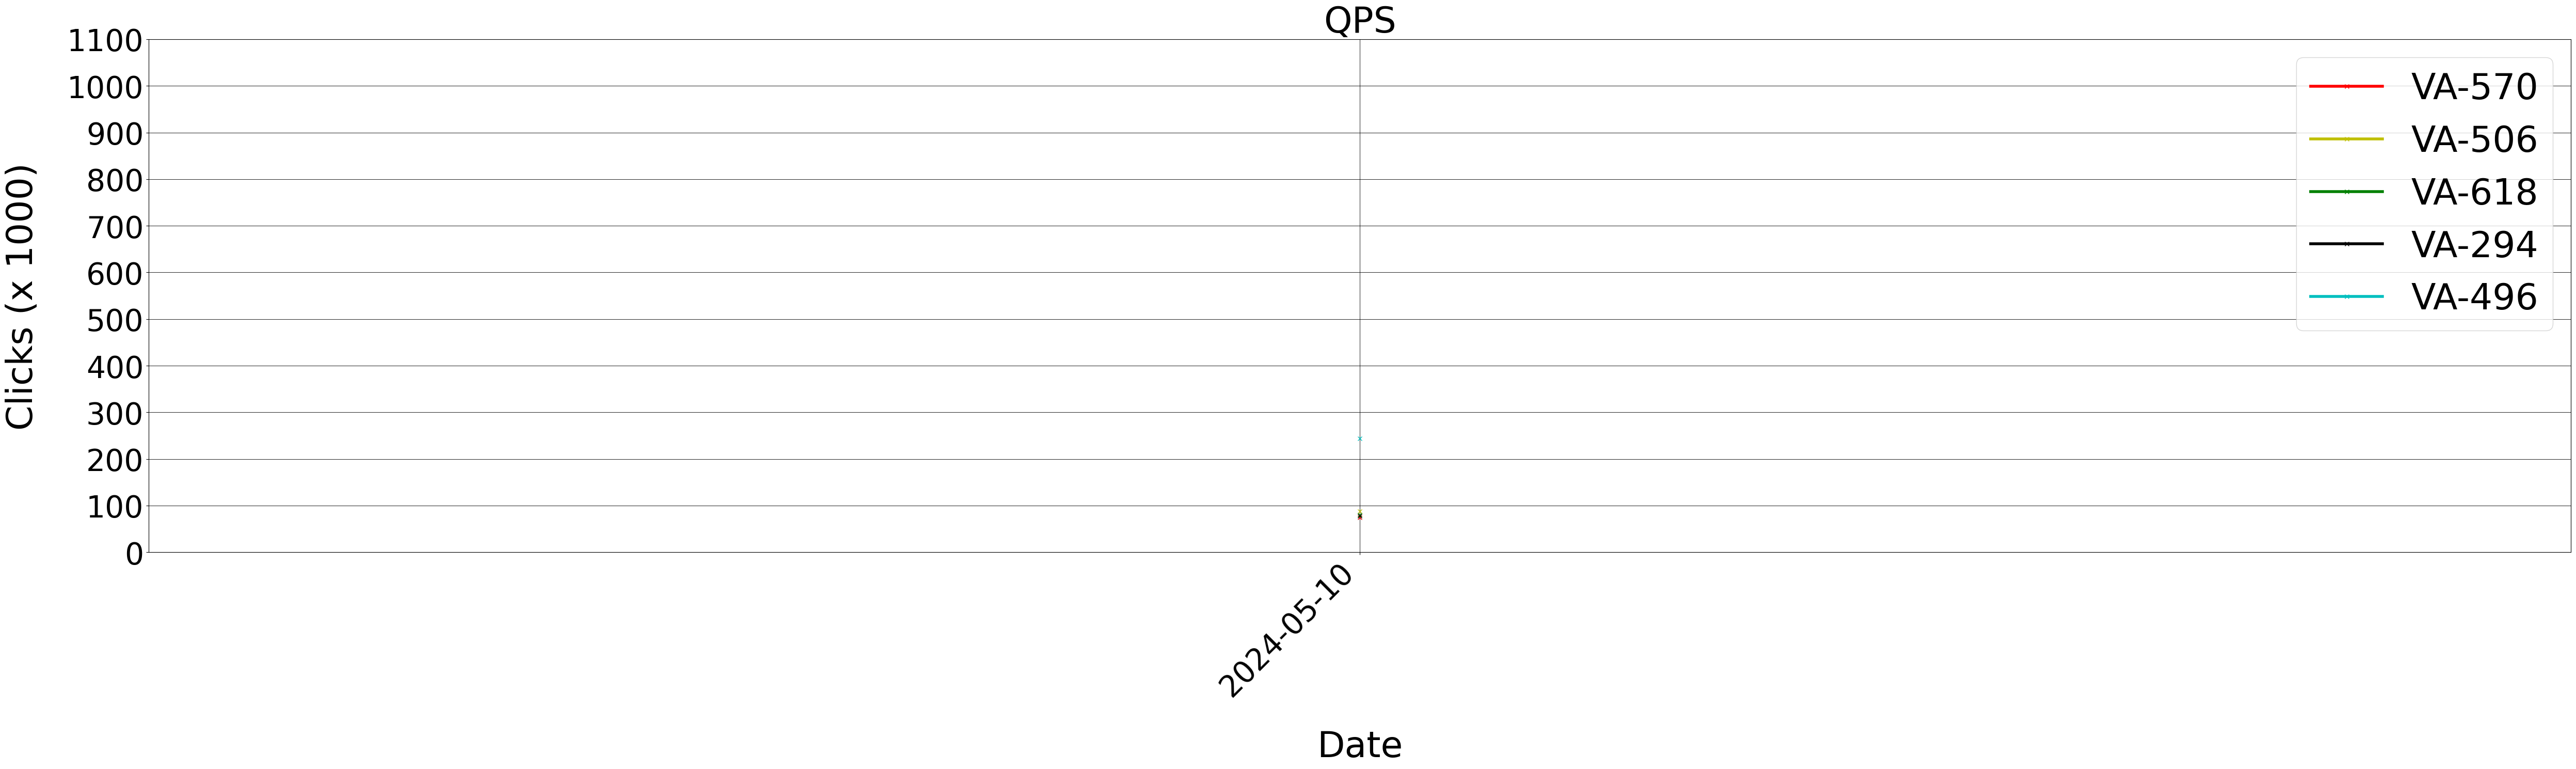

In [31]:
try:
    if __name__ == "__main__":

        #public s3 path. 
        s3_path = 'datasci-assignment/click_log/2024/05/'

        #Create S3 object to read from public S3-bucket.
        s3 = s3fs.S3FileSystem(anon =  True)

        #getting currect working directory to save the files in landing location. 
        currect_working_directory = os.getcwd().replace("\\", "/")
        logger.info(f"ingestion of data started from s3-path {s3_path}")

        #Start INgesting data in Landing folder.
        destination_path  = ingest_data_from_s3(currect_working_directory, s3, s3_path)
        logger.info(f"ingestion of data Completed successfully at location {destination_path}")


        spark = SparkSession.builder.master("local[*]").appName("click_logs").config("spark.sql.legacy.timeParserPolicy","LEGACY").getOrCreate()
        logger.info(f"SparkSession Created Successfully")
        
        logger.info(f"apply_transformations function started successfully reading data from location : {destination_path}")
        destination_path = apply_transformations(spark,destination_path)
        logger.info(f"apply_transformations function completed saved parquet at location: {destination_path}")
        df = generating_publisher_id_with_maximum_queries(spark, destination_path)
        generatring_line_graph_for_top_5_publishers(df)
        

        
            
except Exception as e:
        logger.info(f"Error has been encountered at main {e}")

In [29]:
# s3_path = 'datasci-assignment/'
# #Create S3 object to read from public S3-bucket.
# s3 = s3fs.S3FileSystem(anon =  True)

# #Start INgesting data in Landing folder.
# ingest_data_from_s3(os.getcwd(), s3, s3_path)
print(f'{str(os.getcwd()).replace("\\", "/")}'/Landing1/click_log/2024/05/')

SyntaxError: leading zeros in decimal integer literals are not permitted; use an 0o prefix for octal integers (2642218053.py, line 7)

In [ ]:
print(str(os.getcwd()).replace("\\", "/"))
C:\Users\Admin\Downloads\read_public_s3\Landing

SyntaxError: unexpected character after line continuation character (2875104363.py, line 2)

In [ ]:

spark = SparkSession.builder.master("local[*]").appName("click_logs").getOrCreate()

----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 62389)
Traceback (most recent call last):
  File "C:\Program Files\Python311\Lib\socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "C:\Program Files\Python311\Lib\socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "C:\Program Files\Python311\Lib\socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "C:\Program Files\Python311\Lib\socketserver.py", line 755, in __init__
    self.handle()
  File "c:\Users\Admin\Downloads\read_public_s3\.venv\Lib\site-packages\pyspark\accumulators.py", line 295, in handle
    poll(accum_updates)
  File "c:\Users\Admin\Downloads\read_public_s3\.venv\Lib\site-packages\pyspark\accumulators.py", line 267, in poll
    if self.rfile in r and func():
                           ^^^^^^
  

In [ ]:
folder_path = []
actual_path = str(os.getcwd()).replace("\\", "/")
for outside in os.listdir(f"{actual_path}/Landing/click_log/2024/05/"):
    for inside in os.listdir(f"{actual_path}/Landing/click_log/2024/05/{outside}/"):
        folder_path.append(f'{outside}/{inside}')
print(folder_path)

['10/00', '10/01', '10/02', '10/03', '10/04', '10/05', '10/06', '10/07', '10/08', '10/09', '10/10', '10/11', '10/12', '10/13', '10/14', '10/15', '10/16', '10/17', '10/18', '10/19', '10/20', '10/21', '10/22', '10/23', '11/00', '11/01', '11/02', '11/03', '11/04', '11/05', '11/06', '11/07', '11/08', '11/09', '11/10', '11/11', '11/12', '11/13', '11/14', '11/15', '11/16', '11/17', '11/18', '11/19', '11/20', '11/21', '11/22', '11/23', '12/00', '12/01', '12/02', '12/03', '12/04', '12/05', '12/06', '12/07', '12/08', '12/09', '12/10', '12/11', '12/12', '12/13', '12/14', '12/15', '12/16', '12/17', '12/18', '12/19', '12/20', '12/21', '12/22', '12/23', '13/00', '13/01', '13/02', '13/03', '13/04', '13/05', '13/06', '13/07', '13/08', '13/09', '13/10', '13/11', '13/12', '13/13', '13/14', '13/15', '13/16', '13/17', '13/18', '13/19', '13/20', '13/21', '13/22', '13/23', '14/00', '14/01', '14/02', '14/03', '14/04', '14/05', '14/06', '14/07', '14/08', '14/09', '14/10', '14/11', '14/12', '14/13', '14/14', 

In [ ]:

for path in folder_path:
    print(path)
    df = spark.read.option("inferSchema", True).option("mode", "PERMISSIVE").option("multiLine", True).json(f"{actual_path}/Landing/click_log/2024/05/{path}/")
    # df.printSchema()
    df = df.select('*', "ip_geo.*", "query.*").drop("query", "ip_geo")
    # df.write.format("parquet")
    df = df.withColumn("real_filepath", input_file_name())

    df = df.withColumn("actual_file" , split(df.real_filepath, '/',limit=-1))
    df = df.withColumn("count_file", size(df.actual_file))
    df = df.withColumn("actual_file" , df.actual_file[col("count_file")-1]).drop("count_file")
    df = df.withColumn("file_creation_date", get_file_generation_date_udf(col("actual_file")))
    df = df.withColumn("date", split(col("file_creation_date"), " ").getItem(0))


    df = df.withColumn("file_creation_date", df["file_creation_date"].cast(DateType()))
    # df.printSchema()
    # display(df)

    df = df.toDF(*get_unique_column_names(df.columns))
    df.write.partitionBy(df.columns[-1]).mode("overwrite").format("parquet").save(f"{actual_path}/clean")
    # df.show()
    # break

10/00
['campaign_id', 'click_time', 'creative_id', 'device_id', 'gaid', 'idfa', 'ip', 'isGlobalIpFlag', 'p_click_id', 'publisher_id', 'req', 'sub_publisher_id', 'timestamp', 'city', 'city_name', 'country', 'lat', 'lon', 'metro_code', 'state', 'zip', 'campaign_id', 'click_id', 'creative_id', 'gaid', 'idfa', 'is_incentivized', 'model', 'os_version', 'publisher_id', 'sub_publisher_id', 'user_agent', 'real_filepath', 'actual_file', 'file_creation_date']
10/01
['campaign_id', 'click_time', 'creative_id', 'device_id', 'gaid', 'ip', 'isGlobalIpFlag', 'p_click_id', 'publisher_id', 'req', 'sub_publisher_id', 'timestamp', 'city', 'city_name', 'country', 'lat', 'lon', 'metro_code', 'state', 'zip', 'campaign_id', 'click_id', 'creative_id', 'gaid', 'is_incentivized', 'model', 'os_version', 'publisher_id', 'sub_publisher_id', 'user_agent', 'real_filepath', 'actual_file', 'file_creation_date']
10/02
['campaign_id', 'click_time', 'creative_id', 'device_id', 'gaid', 'ip', 'isGlobalIpFlag', 'p_click_id'

In [ ]:
df.columns[-1]

'file_creation_date_34'

In [ ]:
from pyspark.sql.functions import *

df = spark.read.option("InferSchema", "True").option("mode", "PERMISSIVE").option("multiLine", True).json("C:/Users/Admin/Downloads/read_public_s3/Landing/click_log/2024/05/10/00/")
# df = df.select('*', "ip_geo.*", "query.*").drop("query", "ip_geo")
# # df.write.format("parquet")
# df = df.withColumn("real_filepath", input_file_name())

# df = df.withColumn("actual_file" , split(df.real_filepath, '/',limit=-1))
# df = df.withColumn("count_file", size(df.actual_file))
# df = df.withColumn("actual_file" , df.actual_file[col("count_file")-1]).drop("count_file")
# df.withColum("filepath", F.regexp_extract("filepath", "State=(.+)\.snappy\.parquet", 1)

In [ ]:
a = []
for i in df.dtypes:

    # print(i[0])
    # print(len(i), isinstance(df.schema[i[0]].dataType, StructType))
    if isinstance(df.schema[i[0]].dataType, StructType):
        # print(df.schema[i[0]].dataType.fieldNames())
        # for columns_str in df.schema[i[0]].dataType.fieldNames():
        #     print(columns_str)
        #     print(df.schema[f'{i[0]}.{columns_str}'].dataType)
        # if isinstance(df.schema[f'{i[0]}.{columns_str}'].dataType, StructType):
        #     print("yes")
            # break
        a += list(map(lambda column_name: f'{i[0]}.{column_name}' ,df.schema[i[0]].dataType.fieldNames()))
    else:
        if i[0] not in a:

            a.append(i[0])
    # print(i[1])
    # a = i[1].replace("struct<", "").replace(">", "")
    # print(to_json(a))
    # ddl_schema = StructType.fromDDL(a)

    # Show the generated schema
    # ddl_schema.printSchema()
    # break
# print(list(list(column_structure)[0]))
print(a)
df = df.select(*a)


['campaign_id', 'click_time', 'creative_id', 'device_id', 'gaid', 'idfa', 'ip', 'ip_geo.city', 'ip_geo.city_name', 'ip_geo.country', 'ip_geo.lat', 'ip_geo.lon', 'ip_geo.metro_code', 'ip_geo.state', 'ip_geo.zip', 'isGlobalIpFlag', 'p_click_id', 'publisher_id', 'query.campaign_id', 'query.click_id', 'query.creative_id', 'query.gaid', 'query.idfa', 'query.is_incentivized', 'query.model', 'query.os_version', 'query.publisher_id', 'query.sub_publisher_id', 'query.user_agent', 'req', 'sub_publisher_id', 'timestamp']


In [ ]:
df.printSchema()

root
 |-- campaign_id: string (nullable = true)
 |-- click_time: long (nullable = true)
 |-- creative_id: string (nullable = true)
 |-- device_id: string (nullable = true)
 |-- gaid: string (nullable = true)
 |-- idfa: string (nullable = true)
 |-- ip: string (nullable = true)
 |-- city: string (nullable = true)
 |-- city_name: string (nullable = true)
 |-- country: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- lon: double (nullable = true)
 |-- metro_code: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zip: string (nullable = true)
 |-- isGlobalIpFlag: long (nullable = true)
 |-- p_click_id: string (nullable = true)
 |-- publisher_id: string (nullable = true)
 |-- campaign_id: string (nullable = true)
 |-- click_id: string (nullable = true)
 |-- creative_id: string (nullable = true)
 |-- gaid: string (nullable = true)
 |-- idfa: string (nullable = true)
 |-- is_incentivized: string (nullable = true)
 |-- model: string (nullable = true)
 |-- os_ve

In [ ]:
df.show(truncate=False)

+-----------+-------------+-----------+------------------------------------+------------------------------------+------------------------------------+---------------+--------------+-------------------------------------------------------------------+------------+--------------------+----------------------------------------------+-------------+-------+----------+-------+-------+-------+----------+-----+------+-----------+-------------------------------------------------------------------+-----------+------------------------------------+------------------------------------+---------------+----------+----------+------------+----------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
df = spark.read.option("mode", "PERMISSIVE").option("multiLine", True).json("C:/Users/Admin/Downloads/read_public_s3/Landing/postback-log/2024/05/10/00/performance_postback_log-1-2024-05-10-00-00-33-efc64b50-edbc-4a15-97ae-0aaefa93ce79")
# df = df.select('*', "ip_geo.*", "query.*").drop("query", "ip_geo")
# # df.write.format("parquet")
# df = df.withColumn("real_filepath", input_file_name())

# df = df.withColumn("actual_file" , split(df.real_filepath, '/',limit=-1))
# df = df.withColumn("count_file", size(df.actual_file))
# df = df.withColumn("actual_file" , df.actual_file[col("count_file")-1]).drop("count_file")
# # df.withColum("filepath", F.regexp_extract("filepath", "State=(.+)\.snappy\.parquet", 1)


a = []
for i in df.dtypes:

    # print(i[0])
    # print(len(i), isinstance(df.schema[i[0]].dataType, StructType))
    if isinstance(df.schema[i[0]].dataType, StructType):
        # print(df.schema[i[0]].dataType.fieldNames())
        # for columns_str in df.schema[i[0]].dataType.fieldNames():
        #     print(columns_str)
        #     print(df.schema[f'{i[0]}.{columns_str}'].dataType)
        # if isinstance(df.schema[f'{i[0]}.{columns_str}'].dataType, StructType):
        #     print("yes")
            # break
        for column_name in df.schema[i[0]].dataType.fieldNames():
            df = df.select(f'{i[0]}.{column_name}')
        # a += list(map(lambda column_name: f'{i[0]}.{column_name}' ,df.schema[i[0]].dataType.fieldNames()))
    else:
        if i[0] not in a:

            a.append(i[0])
    # print(i[1])
    # a = i[1].replace("struct<", "").replace(">", "")
    # print(to_json(a))
    # ddl_schema = StructType.fromDDL(a)

    # Show the generated schema
    # ddl_schema.printSchema()
    # break
# print(list(list(column_structure)[0]))
print(a)
# df = df.select(*a)
df.show()

AnalysisException: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column or function parameter with name `click_config`.`click_id` cannot be resolved. Did you mean one of the following? [`campaign_id`].;
'Project ['click_config.click_id]
+- Project [click_config#12917.campaign_id AS campaign_id#12925]
   +- Relation [click_config#12917,query#12918,req#12919,timestamp#12920L] json


In [ ]:
# for i in df.columns:
#     # print(i)
#     a = df[i].dataType
#     print(a)


#Get All column names and it's types
for field in df.schema.fields:
    # print(field)
    print(field.name +" , "+str(field.dataType))

click_config , StructType([StructField('campaign_id', StringType(), True), StructField('click_id', StringType(), True), StructField('click_time', LongType(), True), StructField('creative_id', StringType(), True), StructField('device_id', StringType(), True), StructField('dummy_publisher_id', StringType(), True), StructField('events', StructType([StructField('0', StructType([StructField('ev', StringType(), True), StructField('tm', LongType(), True)]), True), StructField('1', StructType([StructField('ev', StringType(), True), StructField('pubEventId', LongType(), True), StructField('query', StructType([StructField('attribution_type', StringType(), True)]), True), StructField('sendToPub', LongType(), True), StructField('status', LongType(), True), StructField('ts', LongType(), True)]), True), StructField('2', StructType([StructField('ev', StringType(), True), StructField('pubEventId', LongType(), True), StructField('query', StructType([StructField('attribution_type', StringType(), True)])

In [ ]:
a = []
for i in df.dtypes:

    # print(i[0])
    # print(len(i), isinstance(df.schema[i[0]].dataType, StructType))
    if isinstance(df.schema[i[0]].dataType, StructType):
        # print(df.schema[i[0]].dataType.fieldNames())
        # for columns_str in df.schema[i[0]].dataType.fieldNames():
        #     print(columns_str)
        #     print(df.schema[f'{i[0]}.{columns_str}'].dataType)
        # if isinstance(df.schema[f'{i[0]}.{columns_str}'].dataType, StructType):
        #     print("yes")
            # break
        df = df.select(f'{i[0]}.{column_name}')
        a += list(map(lambda column_name: f'{i[0]}.{column_name}' ,df.schema[i[0]].dataType.fieldNames()))
    else:
        if i[0] not in a:

            a.append(i[0])
    # print(i[1])
    # a = i[1].replace("struct<", "").replace(">", "")
    # print(to_json(a))
    # ddl_schema = StructType.fromDDL(a)

    # Show the generated schema
    # ddl_schema.printSchema()
    # break
# print(list(list(column_structure)[0]))
print(a)
df = df.select(*a)


['campaign_id', 'click_id', 'click_time', 'creative_id', 'device_id', 'dummy_publisher_id', 'events.0', 'events.1', 'events.2', 'events.3', 'events.4', 'gaid', 'gross_adv_cost', 'idfa', 'install_count', 'install_time', 'net_adv_cost', 'p_click_id', 'pub_payout', 'pub_valid_conversion', 'publisher_id', 'status', 'status_code', 'sub_campaign_id', 'sub_publisher_id', 'timestamp', 'va_total_conversion', 'va_valid_conversion', 'valid_click', 'adid', 'app_type', 'app_version', 'attribution_type', 'bundle_id', 'bundle_name', 'campaign_name', 'car', 'carrier_name', 'city', 'click_utc', 'country', 'creative_name', 'ctype', 'device_brand', 'device_model', 'device_type', 'device_version', 'event_id', 'event_name', 'event_timestamp', 'event_value', 'install_utc', 'lng', 'mmp', 'op', 'original_pid', 'os', 'os_version', 're', 'ree', 'rt', 'sdk', 'session_ip', 'st', 'sub_id2', 'transaction_amount', 'urlClickId', 'user_agent', 'wifi', 'req']


AnalysisException: [AMBIGUOUS_REFERENCE] Reference `campaign_id` is ambiguous, could be: [`campaign_id`, `campaign_id`].

In [ ]:
df.show()

+-----------+-------------------+-------------+---------------+--------------------+------------------+--------------------+--------------------+--------------+--------------------+-------------+-------------+------------+--------------------+----------+--------------------+------------+------+-----------+---------------+----------------+-------------+-------------------+-------------------+-----------+--------------------+-----------+-----------+----------------+--------------------+--------------------+-----------+--------------------+---+------------+-----+-------------------+-------------+-------+-------------+-----+------------+--------------------+------------+-----------+--------------+--------+----------+---------------+-----------+--------------------+-------------+------+---------+---+------------+-------+----------+------------+---+---+---+-------+-----------+---+----------+----------------+------------------+--------------------+--------------------+----+-------------------

In [ ]:
df.printSchema()

root
 |-- campaign_id: string (nullable = true)
 |-- click_id: string (nullable = true)
 |-- click_time: long (nullable = true)
 |-- creative_id: string (nullable = true)
 |-- device_id: string (nullable = true)
 |-- dummy_publisher_id: string (nullable = true)
 |-- events: struct (nullable = true)
 |    |-- 0: struct (nullable = true)
 |    |    |-- ev: string (nullable = true)
 |    |    |-- tm: long (nullable = true)
 |    |-- 1: struct (nullable = true)
 |    |    |-- ev: string (nullable = true)
 |    |    |-- pubEventId: long (nullable = true)
 |    |    |-- query: struct (nullable = true)
 |    |    |    |-- attribution_type: string (nullable = true)
 |    |    |-- sendToPub: long (nullable = true)
 |    |    |-- status: long (nullable = true)
 |    |    |-- ts: long (nullable = true)
 |    |-- 2: struct (nullable = true)
 |    |    |-- ev: string (nullable = true)
 |    |    |-- pubEventId: long (nullable = true)
 |    |    |-- query: struct (nullable = true)
 |    |    |    |-